# Figures for the heart

## Raster plot

In [1]:
import numpy as np 
import scipy as sp


import matplotlib.pyplot as plt





import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

import networkx as nx

from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp

import jax
from jax import lax, vmap, jit
import jax.random as random
from jax.experimental import sparse


In [2]:

def generate_laplacian(N, M, conduction_block_threshold, sparse_matrix=False, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold


    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    
    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

    # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)
    
    # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

    # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

    # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))


    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix


    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    
    else:
        return laplacian_matrix.todense(), conduction_blocks



In [3]:
N_y=200
N_x=200
N=N_x*N_y
dts=500
L1, c1 = generate_laplacian(N_x,N_y,0, seed=1000, sparse_matrix=True)
L2,c2=generate_laplacian(N_x,N_y,0.35, seed=135, sparse_matrix=True)

In [4]:

def FHN_step(u, v, N, a, b, e, Du, sigma, L, key, delta_t):
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - Du: Diffusion coefficient
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N, y0='wave', a=3, b=0.05, e=1e-2, Du=0.04, L=None, c1=None, sigma=0.0001, stimulus_time=1000, delta_t=0.1, total_time=3000.0, Nconf=3000, key=random.PRNGKey(2)):
    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)

    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    save_interval = num_steps // Nconf
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    def scan_fn(carry, step):
        u, v, key, save_counter, u_saved, v_saved = carry
        key, subkey = random.split(key)
        
        # Apply stimulus to the specified indices
        u = jax.lax.cond((step > 0) & (step % int(stimulus_time / delta_t) == 0),
                          lambda u: u.at[indices].add(0.1),
                          lambda u: u,
                          u)

        u, v = FHN_step(u, v, N, a, b, e, Du, sigma, L, subkey, delta_t)
        
        # Save the configuration at the specified intervals
        save_counter = save_counter + 1
        u_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda u_saved: u_saved.at[save_counter // save_interval - 1].set(u),
                               lambda u_saved: u_saved,
                               u_saved)
        v_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda v_saved: v_saved.at[save_counter // save_interval - 1].set(v),
                               lambda v_saved: v_saved,
                               v_saved)
        
        return (u, v, key, save_counter, u_saved, v_saved), (u, v)

    # Preallocate arrays for saved configurations
    u_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    v_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    
    # Create a range of steps
    steps = jnp.arange(num_steps)
    
    # Run the scan function
    carry = (u, v, key, 0, u_saved, v_saved)
    carry, _ = lax.scan(scan_fn, carry, steps)

    u_saved = carry[4]
    v_saved = carry[5]

    return u_saved, v_saved

In [5]:
def threshold_matrix(matrix: jnp.ndarray, threshold: float) -> jnp.ndarray:
    """
    Scans a JAX matrix and returns a binary matrix where elements above 
    the threshold are 1 and elements below or equal to the threshold are 0.
    
    Parameters:
    matrix (jnp.ndarray): Input JAX matrix.
    threshold (float): Threshold value.
    
    Returns:
    jnp.ndarray: A binary matrix of the same shape as the input.
    """
    # Use jax.numpy.where to create a binary matrix
    return jnp.where(matrix > threshold, 1, 0)


In [5]:
u_sol, v_sol = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(2),delta_t=0.1, total_time=6500, stimulus_time=1300, Nconf=6500)
u_sol2, v_sol2 = run_simulation(N=N, sigma=0.0001,L=L2, c1=c2, key=random.PRNGKey(2),delta_t=0.1, total_time=6500, stimulus_time=1300, Nconf=6500)
u_sol1=u_sol.T
u_sol2=u_sol2.T
binary1=threshold_matrix(u_sol1,0.08)
binary1=binary1.reshape(N_x,N_y,-1)
binary2=threshold_matrix(u_sol2,0.08)
binary2=binary2.reshape(N_x,N_y,-1)


NameError: name 'threshold_matrix' is not defined

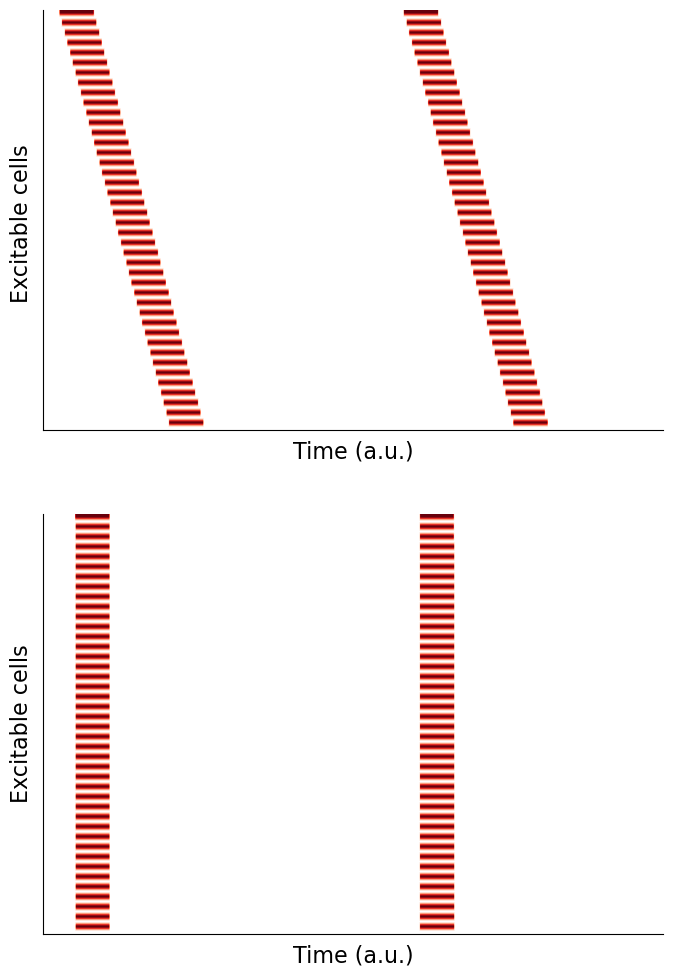

In [15]:
# Get the specific slices

data1 = binary1[20, 4:(N_y-4), :1500]

data2 = binary1[4:(N_y-4), 10, :1500]

# Add blank rows between binary rows for data1
N1, T1 = data1.shape
gap1 = 1  # Gap size (number of blank rows)
data1_with_blanks = np.zeros((N1 * (gap1 + 1), T1))
for i in range(N1):
    data1_with_blanks[i * (gap1 + 1), :] = data1[i, :]

# Add blank rows between binary rows for data2
N2, T2 = data2.shape
gap2 = 1  # Gap size (number of blank rows)
data2_with_blanks = np.zeros((N2 * (gap2 + 1), T2))
for i in range(N2):
    data2_with_blanks[i * (gap2 + 1), :] = data2[i, :]

# Create a custom colormap (transparent for 0, red for 1)
cmap = plt.cm.Reds
cmap = cmap(np.arange(cmap.N))
cmap[0, -1] = 0  # Set the alpha value of the first color (for 0) to 0 (fully transparent)
cmap = plt.matplotlib.colors.ListedColormap(cmap)


# Plot the data
plt.figure(figsize=(8, 12), facecolor='none')

# Plot data1
plt.subplot(2, 1, 1)
plt.imshow(data1_with_blanks, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.ylabel("Excitable cells ", fontsize=16)
plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)

# Plot data2
plt.subplot(2, 1, 2)
plt.imshow(data2_with_blanks, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.ylabel("Excitable cells", fontsize=16)
plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)

plt.show()

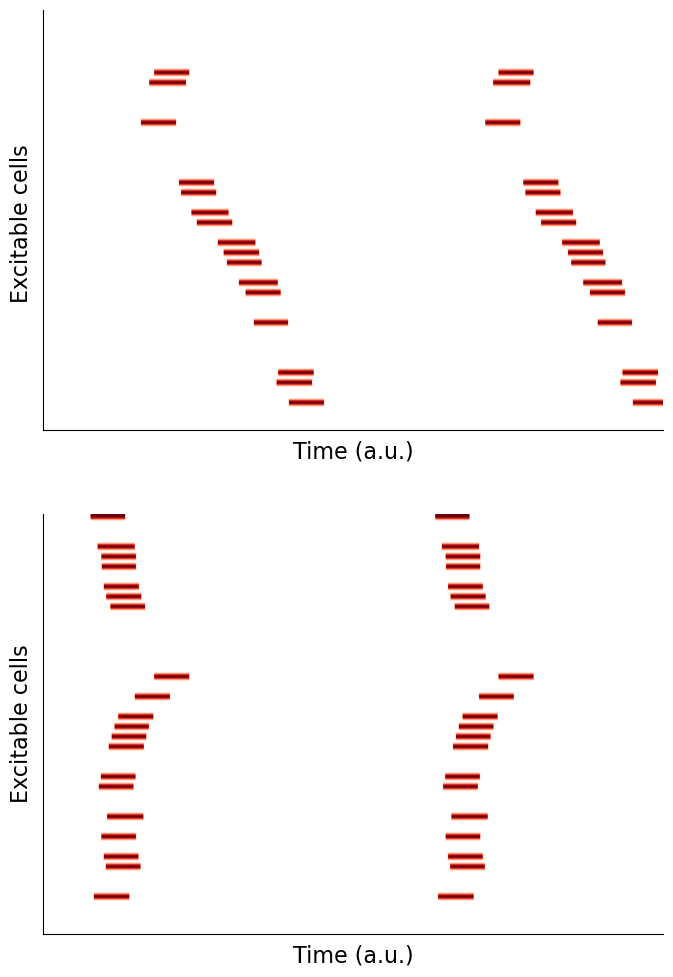

In [16]:
# Get the specific slices

data1 = binary2[20, 4:(N_y-4), :1500]

data2 = binary2[4:(N_y-4), 10, :1500]

# Add blank rows between binary rows for data1
N1, T1 = data1.shape
gap1 = 1  # Gap size (number of blank rows)
data1_with_blanks = np.zeros((N1 * (gap1 + 1), T1))
for i in range(N1):
    data1_with_blanks[i * (gap1 + 1), :] = data1[i, :]

# Add blank rows between binary rows for data2
N2, T2 = data2.shape
gap2 = 1  # Gap size (number of blank rows)
data2_with_blanks = np.zeros((N2 * (gap2 + 1), T2))
for i in range(N2):
    data2_with_blanks[i * (gap2 + 1), :] = data2[i, :]

# Create a custom colormap (transparent for 0, red for 1)
cmap = plt.cm.Reds
cmap = cmap(np.arange(cmap.N))
cmap[0, -1] = 0  # Set the alpha value of the first color (for 0) to 0 (fully transparent)
cmap = plt.matplotlib.colors.ListedColormap(cmap)


# Plot the data
plt.figure(figsize=(8, 12), facecolor='none')

# Plot data1
plt.subplot(2, 1, 1)
plt.imshow(data1_with_blanks, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.ylabel("Excitable cells ", fontsize=16)
plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)

# Plot data2
plt.subplot(2, 1, 2)
plt.imshow(data2_with_blanks, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.ylabel("Excitable cells", fontsize=16)
plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)

plt.show()

([], [])

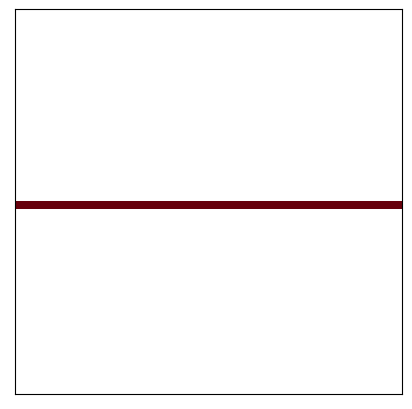

In [21]:

box1 = np.zeros((50, 50))
box1[25, :] = 1  # Set the 26th row to ones

# Create the second box with a column of ones
box2 = np.zeros((50, 50))
box2[:, 25] = 1  # Set the 26th column to ones
# Plot the data
plt.figure(figsize=(5, 5), facecolor='none')

# Plot box1

plt.imshow(box1, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks






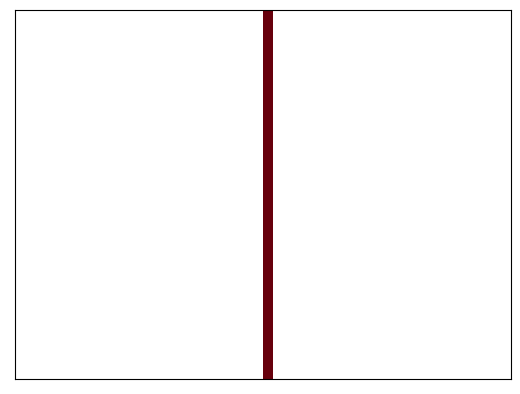

In [ ]:
# Plot box2
plt.figure(figsize=(5, 5), facecolor='none')
plt.imshow(box2, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks

plt.show()

# Making movies

In [18]:
L2,c2=generate_laplacian(N_x,N_y,0.65, seed=145, sparse_matrix=True)
u_sol2, v_sol2 = run_simulation(N=N, sigma=0.0001,L=L2, c1=c2, key=random.PRNGKey(2),delta_t=0.1, total_time=7800, stimulus_time=1300, Nconf=400)
#u_sol1=u_sol.T
u_sol2=u_sol2.T


In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

def create_movie_from_array(array, output_file="movie.mp4", fps=10, frame_skip=5):
    """
    Create a movie from a 3D array of shape (N, N, T).

    Parameters:
        array (numpy.ndarray): Input array of shape (N, N, T).
        output_file (str): Filename for the output movie (e.g., movie.gif).
        fps (int): Frames per second for the movie.
        frame_skip (int): Number of frames to skip to speed up the movie.
    """
    N, _, T = array.shape  # Extract dimensions
    fig, ax = plt.subplots(figsize=(6, 6)) 

    
    # Display the first frame
    img = ax.imshow(array[:, :, 0], cmap="seismic", interpolation="bilinear", vmin=-np.max(np.abs(array)), vmax=np.max(np.abs(array)), aspect='auto')
    #plt.axis("off")
    
    # Add a colorbar with specific ticks
    cbar = fig.colorbar(img, ax=ax, ticks=[-0.9, -0.5, 0, 0.5, 0.9])
    
    cbar.set_label('V', rotation=0, labelpad=15, fontsize=12, color='black')
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  
    
    # Update function for the animation
    def update(frame):
        img.set_data(array[:, :, frame])
        return img,

    # Create the animation with skipped frames
    frames = range(0, T, frame_skip)
    anim = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=True)
    
    # Save as GIF or MP4
    if output_file.endswith(".gif"):
        anim.save(output_file, writer=PillowWriter(fps=fps))
    elif output_file.endswith(".mp4"):
        anim.save(output_file, writer="ffmpeg", fps=fps)
    else:
        raise ValueError("Output file must end with .gif or .mp4")
    
    plt.close(fig)
    print(f"Movie saved to {output_file}")


u_sol2=u_sol2.reshape(N_x,N_y, -1)

#u_sol3=u_sol2[12:(N_x-40),4:(N_x-4),:]


create_movie_from_array(u_sol2, output_file="simulation_p=0.65.gif", fps=100, frame_skip=1)


Movie saved to simulation_p=0.65.gif
